In [1]:
from transformers import AutoTokenizer
import torch
import os
from dotenv import load_dotenv
import matplotlib.pyplot as plt
import numpy as np
import json
from model_wrapper import ModelWrapper, InterventionSettings, Intervention
from utils import format_conversation
from viz import visualize_token_nlls
from collections import defaultdict
from tqdm import tqdm

/root/InputColoring/venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
load_dotenv()

HUGGINGFACE_TOKEN = os.getenv("HF_TOKEN")

In [3]:
MODEL_LLAMA_3_CHAT = "meta-llama/Meta-Llama-3.1-8B-Instruct"

In [4]:
tokenizer = AutoTokenizer.from_pretrained(
    MODEL_LLAMA_3_CHAT, token=HUGGINGFACE_TOKEN
)

In [5]:
tokenizer.pad_token_id = tokenizer.eos_token_id

In [6]:
model = ModelWrapper()

Loading checkpoint shards: 100%|██████████| 4/4 [00:03<00:00,  1.11it/s]


In [7]:
model.reset_hooks()

In [8]:
messages = [
    {"role": "user", "content": "What is the capital of France?"},
    {"role": "assistant", "content": "Paris."},
    {"role": "user", "content": "What do people like to eat there?"},
    {"role": "assistant", "content": "People in Paris like to eat croissants and baguettes."},
    {"role": "user", "content": "That's interesting. What about the weather? What is it like in the summer?"},
]

In [9]:
messages_formatted = format_conversation(messages, tokenizer, add_generation_prompt=True)

In [10]:
print(messages_formatted)

<|start_header_id|>user<|end_header_id|>

What is the capital of France?<|eot_id|><|start_header_id|>assistant<|end_header_id|>

Paris.<|eot_id|><|start_header_id|>user<|end_header_id|>

What do people like to eat there?<|eot_id|><|start_header_id|>assistant<|end_header_id|>

People in Paris like to eat croissants and baguettes.<|eot_id|><|start_header_id|>user<|end_header_id|>

That's interesting. What about the weather? What is it like in the summer?<|eot_id|><|start_header_id|>assistant<|end_header_id|>




In [11]:
tokens = tokenizer.encode(messages_formatted, return_tensors="pt")

In [12]:
print(tokenizer.decode(tokens[0]))

<|begin_of_text|><|start_header_id|>user<|end_header_id|>

What is the capital of France?<|eot_id|><|start_header_id|>assistant<|end_header_id|>

Paris.<|eot_id|><|start_header_id|>user<|end_header_id|>

What do people like to eat there?<|eot_id|><|start_header_id|>assistant<|end_header_id|>

People in Paris like to eat croissants and baguettes.<|eot_id|><|start_header_id|>user<|end_header_id|>

That's interesting. What about the weather? What is it like in the summer?<|eot_id|><|start_header_id|>assistant<|end_header_id|>




In [13]:
per_token_nlls = model.get_per_token_nlls(tokens)

In [14]:
visualize_token_nlls(tokens[0].cpu(), per_token_nlls[0].cpu().float(), tokenizer)

In [15]:
role_nlls = model.get_role_nlls(tokens)

In [16]:
for item in role_nlls:
    token_str = tokenizer.decode(item['tokens']).replace('\n', '\\n')
    print(f"{tokenizer.decode(item['role'])} (NLL={item['nll']}): '{token_str}'")

user (NLL=33.5): '\n\nWhat is the capital of France?'
assistant (NLL=8.125): '\n\nParis.'
user (NLL=25.875): '\n\nWhat do people like to eat there?'
assistant (NLL=34.25): '\n\nPeople in Paris like to eat croissants and baguettes.'
user (NLL=50.5): '\n\nThat's interesting. What about the weather? What is it like in the summer?'
assistant (NLL=0.0): '\n\n'


In [17]:
generation = model.sample(tokens.to(model.device), max_n_tokens=500)

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


In [18]:
print(tokenizer.decode(generation[0]))

<|begin_of_text|><|start_header_id|>user<|end_header_id|>

What is the capital of France?<|eot_id|><|start_header_id|>assistant<|end_header_id|>

Paris.<|eot_id|><|start_header_id|>user<|end_header_id|>

What do people like to eat there?<|eot_id|><|start_header_id|>assistant<|end_header_id|>

People in Paris like to eat croissants and baguettes.<|eot_id|><|start_header_id|>user<|end_header_id|>

That's interesting. What about the weather? What is it like in the summer?<|eot_id|><|start_header_id|>assistant<|end_header_id|>

The weather in Paris can be quite pleasant in the summer. It's usually mild and warm, with average high temperatures ranging from 22-25°C (72-77°F) from June to August. However, it's not uncommon to experience occasional heatwaves, and the city can get quite crowded during the peak tourist season.<|eot_id|>


In [19]:
assistant_token_embedding = model.assistant_token_embedding
user_token_embedding = model.user_token_embedding

In [24]:
intervention = InterventionSettings(
    intervention=Intervention.EMBEDDING_COLOR,
    user_vector=user_token_embedding-assistant_token_embedding,
    assistant_vector=assistant_token_embedding-user_token_embedding,
    norm_factor=0.5
)

In [25]:
model.set_intervention(intervention)

In [26]:
# model.hooks

In [27]:
generation = model.sample(tokens.to(model.device), max_n_tokens=250)
print(tokenizer.decode(generation[0]))

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


<|begin_of_text|><|start_header_id|>user<|end_header_id|>

What is the capital of France?<|eot_id|><|start_header_id|>assistant<|end_header_id|>

Paris.<|eot_id|><|start_header_id|>user<|end_header_id|>

What do people like to eat there?<|eot_id|><|start_header_id|>assistant<|end_header_id|>

People in Paris like to eat croissants and baguettes.<|eot_id|><|start_header_id|>user<|end_header_id|>

That's interesting. What about the weather? What is it like in the summer?<|eot_id|><|start_header_id|>assistant<|end_header_id|>

The weather in Paris can be quite pleasant in the summer. It's usually mild and warm, with average high temperatures ranging from 22°C to 25°C (72°F to 77°F). However, it's not uncommon to experience occasional heatwaves, especially in July and August.

It's also a good idea to pack for occasional rain showers, as Paris can experience sudden downpours even in the summer. But overall, the summer weather in Paris is lovely, making it a great time to visit and enjoy th

In [28]:
per_token_nlls = model.get_per_token_nlls(tokens)
visualize_token_nlls(tokens[0].cpu(), per_token_nlls[0].cpu().float(), tokenizer)

In [31]:
def get_msj_nlls(model: ModelWrapper, dataset_path: str, intervention: InterventionSettings | None = None, model_name: str | None = None):
    with open(dataset_path) as f:
        dataset = json.load(f)
    result = defaultdict(list)
    for row in tqdm(dataset):
        tokens = torch.tensor(row["tokens"]).to(model.device)
        nlls = model.get_role_nlls(tokens)
        result[row['n_shots']].append(nlls)
    result_save_path = dataset_path.replace("processed_data", "results")
    if intervention is not None:
        if model_name is not None:
            result_save_path = result_save_path.replace(".json", f"_{model_name}_{intervention}.json")
        else:
            result_save_path = result_save_path.replace(".json", f"_{intervention}.json")
    elif model_name is not None:
        result_save_path = result_save_path.replace(".json", f"_{model_name}.json")
    os.makedirs(os.path.dirname(result_save_path), exist_ok=True)
    with open(result_save_path, "w") as f:
        json.dump(result, f)
    return result

In [30]:
model.reset_hooks()
msj_jailbreak_nlls = get_msj_nlls(model, "processed_data/test/msjs_jailbreak.json")
msj_recovery_nlls = get_msj_nlls(model, "processed_data/test/msjs_recovery.json")
msj_mean_jailbreak_nlls = get_msj_nlls(model, "processed_data/test/msjs_mean_jailbreak.json")
msj_mean_recovery_nlls = get_msj_nlls(model, "processed_data/test/msjs_mean_recovery.json")

100%|██████████| 240/240 [00:40<00:00,  5.95it/s]


In [31]:
regular_nlls = get_msj_nlls(model, "processed_data/test/regular_conversations.json")

100%|██████████| 119/119 [00:04<00:00, 27.55it/s]


In [32]:
def plot_nlls(results, legend, figsize=(7, 4), title = None):
    fig, ax = plt.subplots(figsize=figsize)
    for r, l in zip(results, legend):
        if isinstance(r, str):
            with open(r) as f:
                r = json.load(f)
        data = sorted([
            (int(k), sum([r[-1]['nll'] for r in v])/len(v)) for k, v in r.items()
        ])
        shots, nlls = zip(*data)
        shots = np.array(shots)
        ax.plot(shots, nlls, 'o-', markersize=5, label=l)
    ax.set_xscale('log', base=2)
    ax.set_yscale('log', base=10)
    ax.set_xlabel('Number of shots')
    ax.set_ylabel('NLL of final assistant response')    
    ax.legend()
    ax.legend(bbox_to_anchor=(1.02, 1), loc='upper left')
    if title:
        ax.set_title(title)
    plt.tight_layout()
    plt.show()

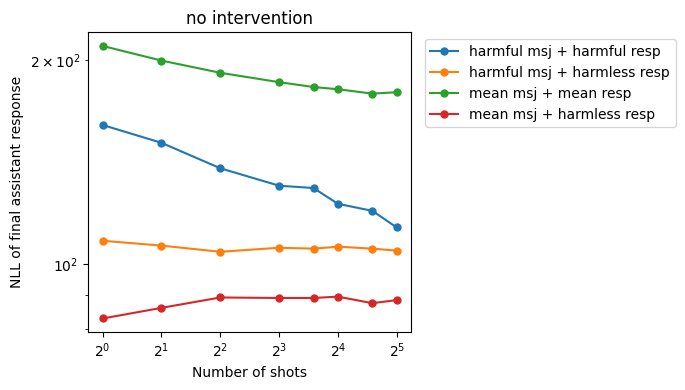

In [33]:
plot_nlls([msj_jailbreak_nlls, msj_recovery_nlls, msj_mean_jailbreak_nlls, msj_mean_recovery_nlls], ['harmful msj + harmful resp', 'harmful msj + harmless resp', 'mean msj + mean resp', 'mean msj + harmless resp'], title="no intervention")

In [29]:
interventions = [
    InterventionSettings(
        intervention=Intervention.RESID_ADD_PROJECT,
        user_vector=user_token_embedding-assistant_token_embedding,
        assistant_vector=assistant_token_embedding-user_token_embedding,
        norm_factor=1
    ),
    InterventionSettings(
        intervention=Intervention.EMBEDDING_COLOR,
        user_vector=user_token_embedding-assistant_token_embedding,
        assistant_vector=assistant_token_embedding-user_token_embedding,
        norm_factor=1
    ),
    InterventionSettings(
        intervention=Intervention.EMBEDDING_COLOR,
        user_vector=user_token_embedding,
        assistant_vector=assistant_token_embedding,
        norm_factor=0.75
    ),
    InterventionSettings(
        intervention=Intervention.RESID_ADD_PROJECT,
        user_vector=user_token_embedding,
        assistant_vector=assistant_token_embedding,
        norm_factor=0.75
    ),
]

100%|██████████| 240/240 [01:25<00:00,  2.80it/s]


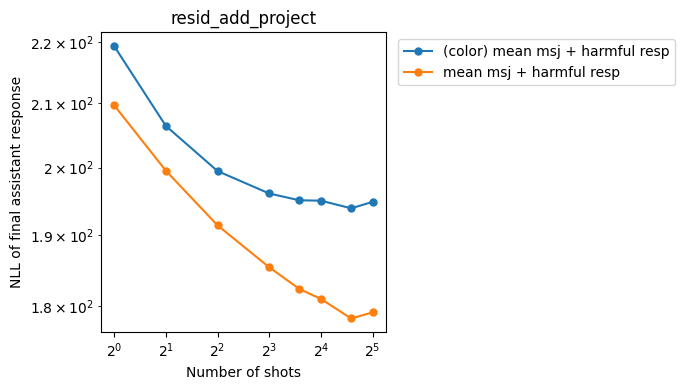

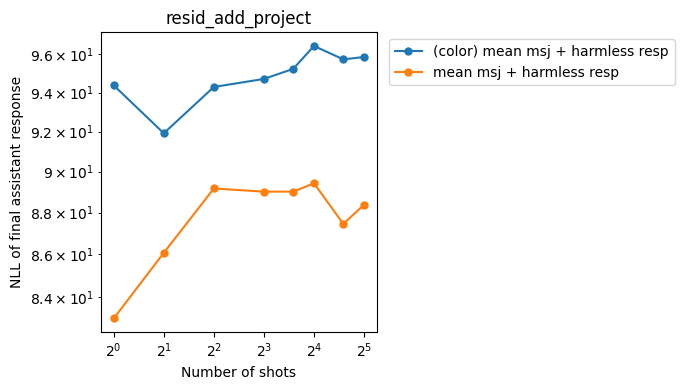

100%|██████████| 240/240 [01:23<00:00,  2.89it/s]


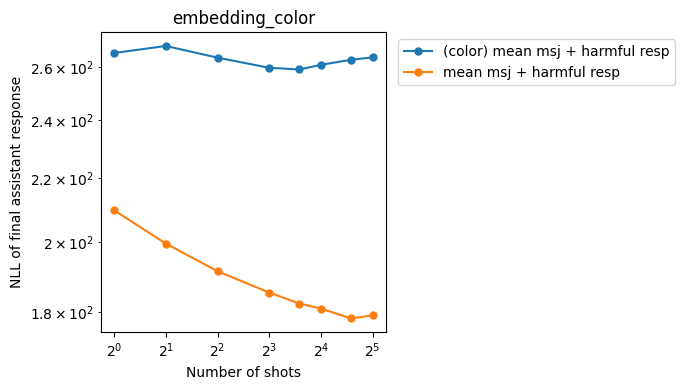

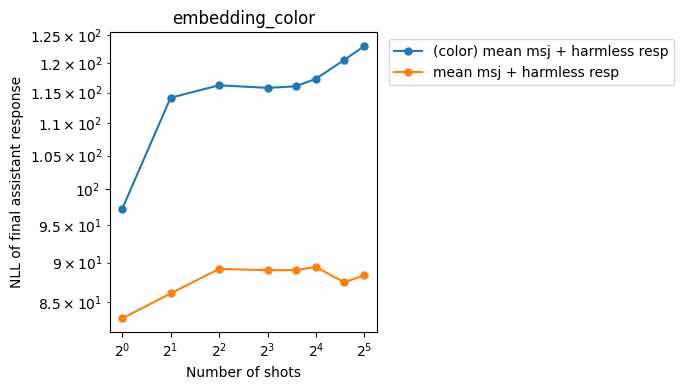

100%|██████████| 240/240 [01:22<00:00,  2.90it/s]


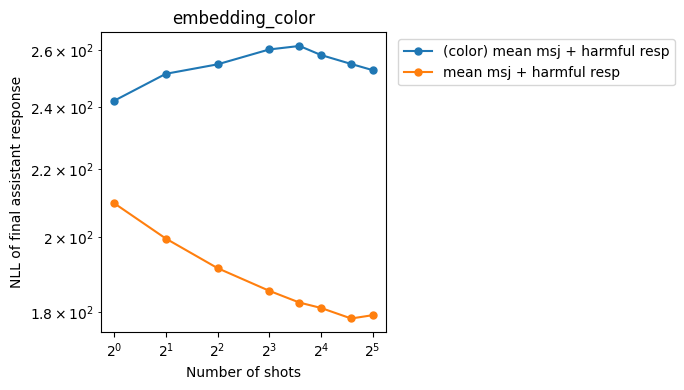

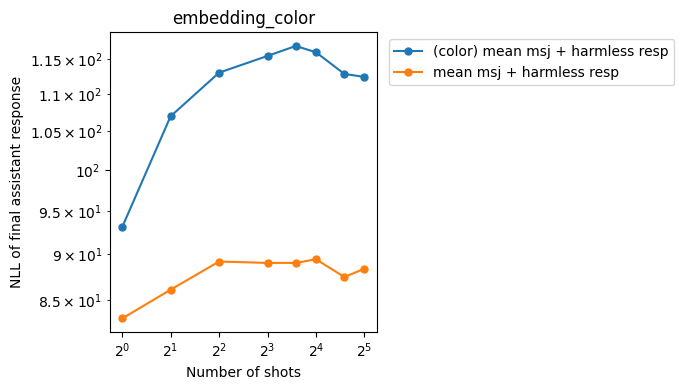

100%|██████████| 240/240 [01:25<00:00,  2.80it/s]


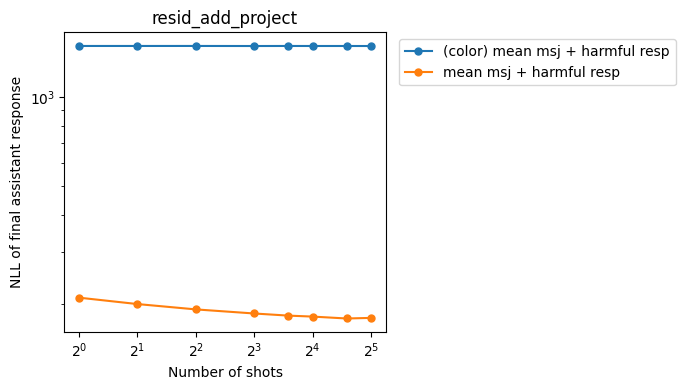

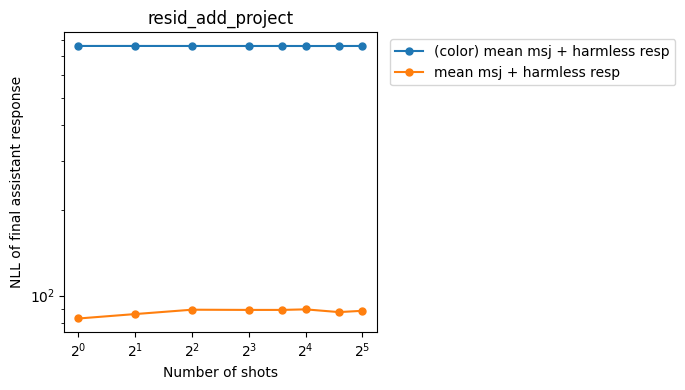

In [35]:
for i in interventions:
    model.set_intervention(i)
    # msj_jailbreak_nlls_colored = get_msj_nlls(model, "processed_data/test/msjs_jailbreak.json", intervention=i)
    # msj_recovery_nlls_colored = get_msj_nlls(model, "processed_data/test/msjs_recovery.json", intervention=i)
    msj_mean_jailbreak_nlls_colored = get_msj_nlls(model, "processed_data/test/msjs_mean_jailbreak.json", intervention=i)
    msj_mean_recovery_nlls_colored = get_msj_nlls(model, "processed_data/test/msjs_mean_recovery.json", intervention=i)
    # regular_nlls_colored = get_msj_nlls(model, "processed_data/test/regular_conversations.json", intervention=i)
    # plot_nlls([msj_jailbreak_nlls_colored, msj_jailbreak_nlls], ['(color) harmful msj + harmful resp', 'harmful msj + harmful resp'], title=str(i))
    # plot_nlls([msj_recovery_nlls_colored, msj_recovery_nlls], ['(color) harmful msj + harmless resp', 'harmful msj + harmless resp'], title=str(i))
    plot_nlls([msj_mean_jailbreak_nlls_colored, "results/test/msjs_mean_jailbreak.json"], ['(color) mean msj + harmful resp', 'mean msj + harmful resp'], title=str(i))
    plot_nlls([msj_mean_recovery_nlls_colored, "results/test/msjs_mean_recovery.json"], ['(color) mean msj + harmless resp', 'mean msj + harmless resp'], title=str(i))
    # plot_nlls([regular_nlls_colored, regular_nlls], ['(color) regular conversations', 'regular conversations'], title=str(i))

## analyzing finetuned versions

In [6]:
model = ModelWrapper()
user_token_embedding = model.user_token_embedding
assistant_token_embedding = model.user_token_embedding
add_project_inter = InterventionSettings(
    intervention=Intervention.RESID_ADD_PROJECT,
    user_vector=user_token_embedding,
    assistant_vector=assistant_token_embedding,
)
embedding_color_inter = InterventionSettings(
    intervention=Intervention.EMBEDDING_COLOR,
    user_vector=user_token_embedding,
    assistant_vector=assistant_token_embedding,
)  

Loading checkpoint shards: 100%|██████████| 4/4 [00:03<00:00,  1.22it/s]


In [7]:
model.load_weights("saved_models/resid_add_project", use_lora=True)
model.set_intervention(add_project_inter) 

loaded weights from saved_models/resid_add_project using LORA: True
you probably want to call model.set_intervention(...) to set up any intervention hooks


In [10]:
msj_jailbreak_nlls_colored = get_msj_nlls(model, "processed_data/test/msjs_jailbreak.json", intervention=add_project_inter, model_name="train_resid_add_project")
msj_recovery_nlls_colored = get_msj_nlls(model, "processed_data/test/msjs_recovery.json", intervention=add_project_inter, model_name="train_resid_add_project")
msj_mean_jailbreak_nlls_colored = get_msj_nlls(model, "processed_data/test/msjs_mean_jailbreak.json", intervention=add_project_inter, model_name="train_resid_add_project")
msj_mean_recovery_nlls_colored = get_msj_nlls(model, "processed_data/test/msjs_mean_recovery.json", intervention=add_project_inter, model_name="train_resid_add_project")
regular_nlls_colored = get_msj_nlls(model, "processed_data/test/regular_conversations.json", intervention=add_project_inter, model_name="train_resid_add_project")

100%|██████████| 119/119 [00:08<00:00, 13.44it/s]


NameError: name 'plot_nlls' is not defined

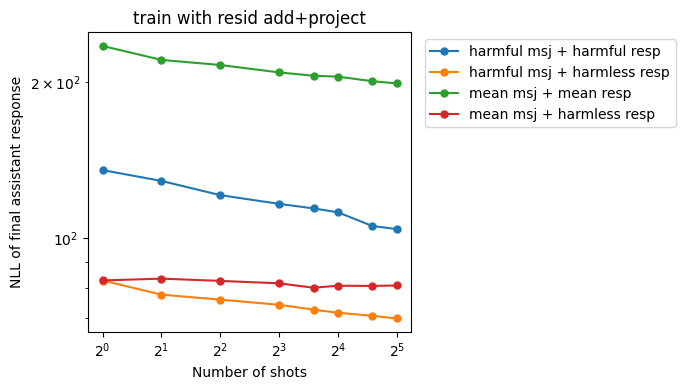

In [12]:
plot_nlls([msj_jailbreak_nlls_colored, msj_recovery_nlls_colored, msj_mean_jailbreak_nlls_colored, msj_mean_recovery_nlls_colored], ['harmful msj + harmful resp', 'harmful msj + harmless resp', 'mean msj + mean resp', 'mean msj + harmless resp'], title="train with resid add+project")

In [14]:
model = ModelWrapper()
model.load_weights("saved_models/embedding_color", use_lora=True)
model.set_intervention(embedding_color_inter) 

Loading checkpoint shards: 100%|██████████| 4/4 [00:03<00:00,  1.11it/s]


loaded weights from saved_models/embedding_color using LORA: True
you probably want to call model.set_intervention(...) to set up any intervention hooks


In [15]:
msj_jailbreak_nlls_colored = get_msj_nlls(model, "processed_data/test/msjs_jailbreak.json", intervention=embedding_color_inter, model_name="train_embedding_color")
msj_recovery_nlls_colored = get_msj_nlls(model, "processed_data/test/msjs_recovery.json", intervention=embedding_color_inter, model_name="train_embedding_color")
msj_mean_jailbreak_nlls_colored = get_msj_nlls(model, "processed_data/test/msjs_mean_jailbreak.json", intervention=embedding_color_inter, model_name="train_embedding_color")
msj_mean_recovery_nlls_colored = get_msj_nlls(model, "processed_data/test/msjs_mean_recovery.json", intervention=embedding_color_inter, model_name="train_embedding_color")
regular_nlls_colored = get_msj_nlls(model, "processed_data/test/regular_conversations.json", intervention=embedding_color_inter, model_name="train_embedding_color")

100%|██████████| 119/119 [00:07<00:00, 15.13it/s]


In [12]:
model = ModelWrapper()
model.load_weights("saved_models/None", use_lora=True)

Loading checkpoint shards: 100%|██████████| 4/4 [00:03<00:00,  1.00it/s]


loaded weights from saved_models/None using LORA: True
you probably want to call model.set_intervention(...) to set up any intervention hooks


In [15]:
msj_jailbreak_nlls_colored = get_msj_nlls(model, "processed_data/test/msjs_jailbreak.json", intervention=None, model_name="train")
msj_recovery_nlls_colored = get_msj_nlls(model, "processed_data/test/msjs_recovery.json", intervention=None, model_name="train")
msj_mean_jailbreak_nlls_colored = get_msj_nlls(model, "processed_data/test/msjs_mean_jailbreak.json", intervention=None, model_name="train")
msj_mean_recovery_nlls_colored = get_msj_nlls(model, "processed_data/test/msjs_mean_recovery.json", intervention=None, model_name="train")
regular_nlls_colored = get_msj_nlls(model, "processed_data/test/regular_conversations.json", intervention=None, model_name="train")

  3%|▎         | 7/240 [00:01<01:07,  3.44it/s]

100%|██████████| 119/119 [00:05<00:00, 23.72it/s]


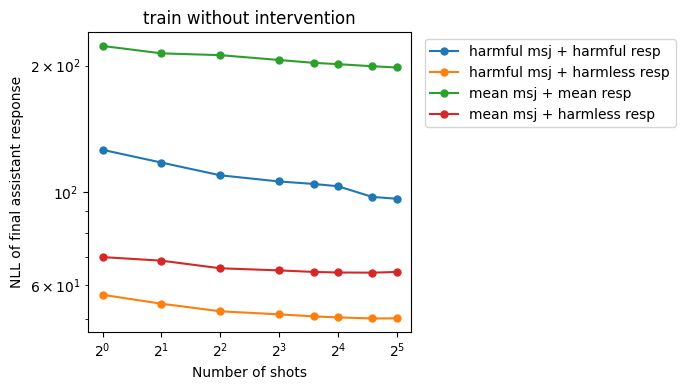

In [20]:
plot_nlls([msj_jailbreak_nlls_colored, msj_recovery_nlls_colored, msj_mean_jailbreak_nlls_colored, msj_mean_recovery_nlls_colored], ['harmful msj + harmful resp', 'harmful msj + harmless resp', 'mean msj + mean resp', 'mean msj + harmless resp'], title="train without intervention")

In [21]:
def plot_experiment(exp_name):
    plot_nlls([f"results/test/msjs_jailbreak_{exp_name}.json", "results/test/msjs_jailbreak.json"], [exp_name, 'no intervention'], title="harmful msj + harmful resp")
    plot_nlls([f"results/test/msjs_mean_jailbreak_{exp_name}.json", "results/test/msjs_mean_jailbreak.json"], [exp_name, 'no intervention'], title="mean msj + mean resp")
    plot_nlls([f"results/test/msjs_recovery_{exp_name}.json", "results/test/msjs_recovery.json"], [exp_name, 'no intervention'], title="harmful msj + harmless resp")
    plot_nlls([f"results/test/msjs_mean_recovery_{exp_name}.json", "results/test/msjs_mean_recovery.json"], [exp_name, 'no intervention'], title="mean msj + harmless resp")
    plot_nlls([f"results/test/regular_conversations_{exp_name}.json", "results/test/regular_conversations.json"], [exp_name, 'no intervention'], title="regular conversations")


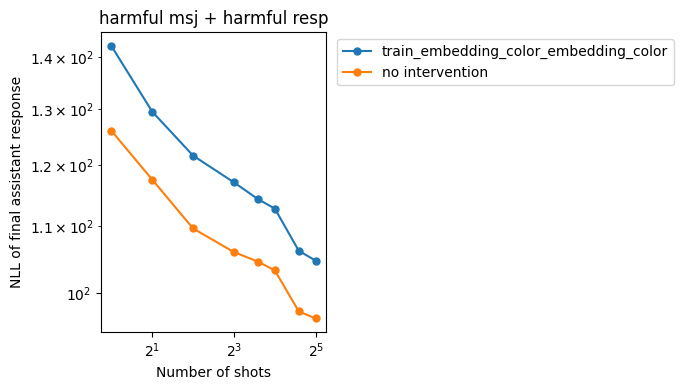

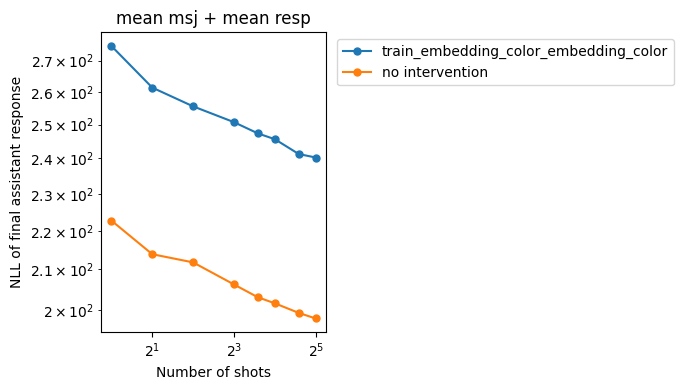

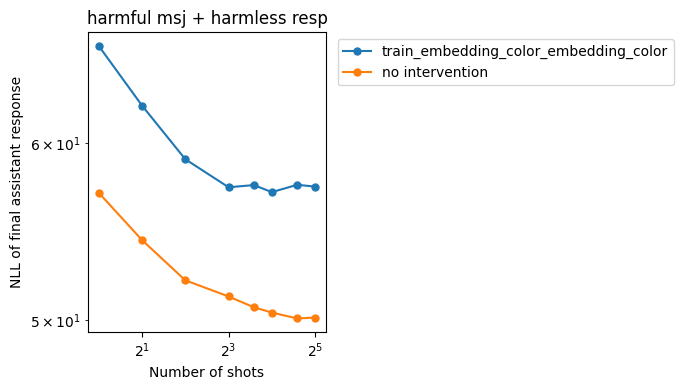

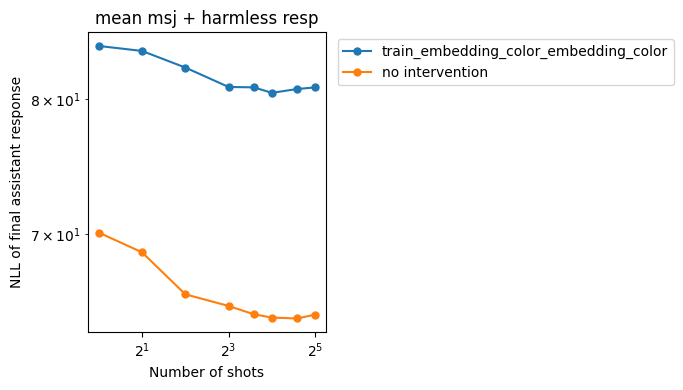

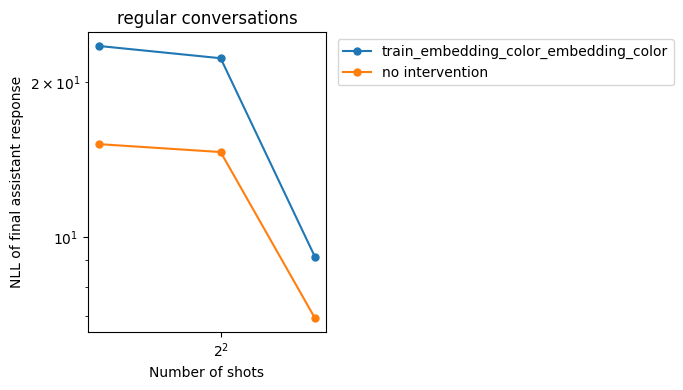

In [22]:
plot_experiment("train_embedding_color_embedding_color")

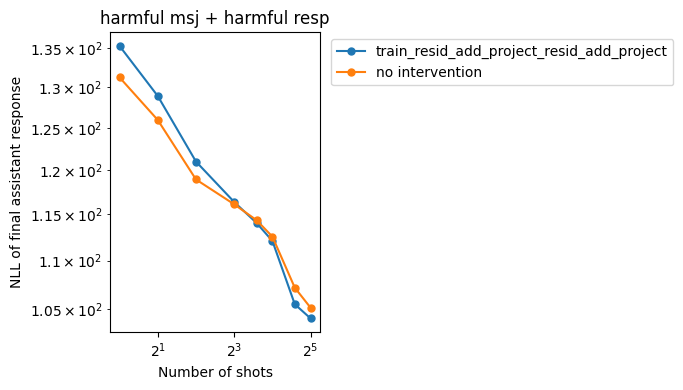

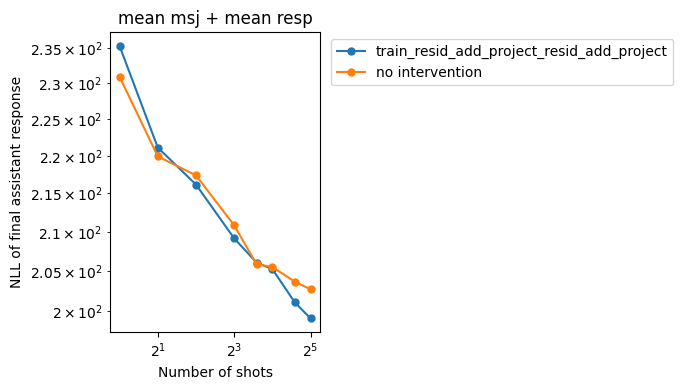

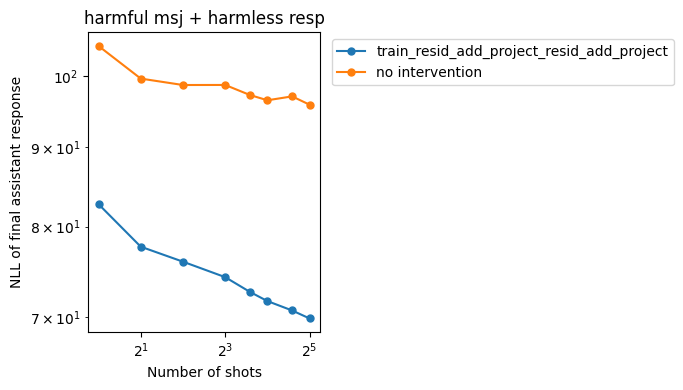

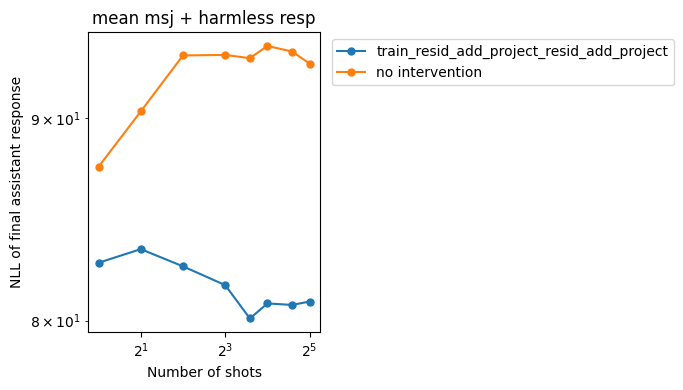

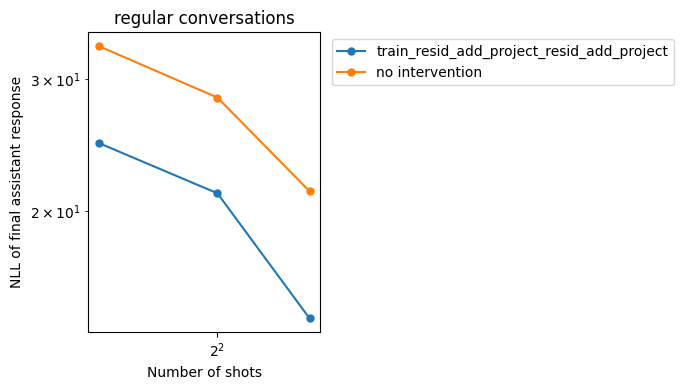

In [11]:
plot_experiment("train_resid_add_project_resid_add_project")

FileNotFoundError: [Errno 2] No such file or directory: 'results/test/msjs_jailbreak_train.json'

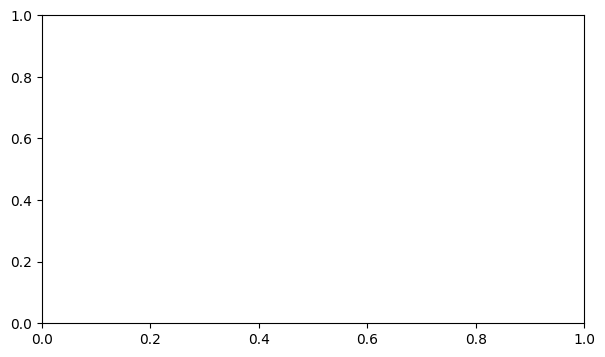

In [16]:
plot_experiment("train")